# Разработка решения для интернет-магазина "В один клик"

<h1>Введение</h1>

Цель задачи - разработать решение для интернет-магазина, позволяющее персонализировать предложения постоянным клиентам с целью увеличения их покупательской способности.
  
<h3>Описание данных</h3> 


Файл market_file.csv. Здесь содержатся данные о поведении покупателя на сайте.

id — номер покупателя в корпоративной базе данных.<br>
Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».<br>
Тип сервиса — уровень сервиса, например «премиум» и «стандарт».<br>
Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.<br>
Маркет_актив\_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. <br>
Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.<br>
Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.<br>
Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.<br>
Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.<br>
Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.<br>
Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.<br>
Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.<br>
Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.<br>

Файл market_money.csv. Здесь содержатся данные о выручке, которую получает магазин с покупателя.

id — номер покупателя в корпоративной базе данных.<br>
Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.<br>
Выручка — сумма выручки за период.<br>

Файл market_time.csv. Здесь содержатся данные о времени (в минутах), которое покупатель провёл на сайте.

id — номер покупателя в корпоративной базе данных.<br>
Период — название периода, во время которого зафиксировано общее время.<br>
минут — значение времени, проведённого на сайте, в минутах.<br>

Файл money.csv. Здесь содержатся данные о среднемесячной прибыли на покупателя за последние 3 месяца.

id — номер покупателя в корпоративной базе данных.<br>
Прибыль — значение прибыли.<br>


В процессе работы предстоит изучить полученные данные, провести их предварительную обработку, провести исследовательский анализ данных, корреляционный анализ, построить модель, которая предскажет вероятность снижения покупательской активности клиента, выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
!pip install -U scikit-learn
#!pip install scikit-learn==0.24.1 -q # Это дефолтная версия sklearn в Практикуме и твой код написан под неё, но если вдруг будет другая, то могут возникнуть ошибки.

In [2]:
#необходимая установка
# -q убирает необязательные выводы в командах Linux
!pip install shap

In [3]:
!pip install phik

In [4]:
import pandas as pd
import matplotlib.pyplot as plt 
import phik
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import shap
from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

## Загрузка данных

In [5]:
#ф-ция для вывода осн.инф-ции по датасетам
def dataset_describe(dataset, head=5):
    #print(dataset.info())
    dataset.info()
    display(dataset.head(head))

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')

In [7]:
dataset_describe(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market_money = pd.read_csv('/datasets/market_money.csv')

In [9]:
dataset_describe(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
market_time = pd.read_csv('/datasets/market_time.csv')

In [11]:
dataset_describe(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [12]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [13]:
dataset_describe(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


В датафреймах market_file и money по 1300  записей. В датафрейме market_money 3900 записей. В датафрейме market_time 2600 записей.   В каждом датафрейме в каждом столбце количество non-null значений соответствует количеству строк в датафрейме, то есть везде столбцы заполнены какими-то значениями. Типы данных столбцов в любом из датафреймов вопросов не вызывают.

##  Предобработка данных

Найдем явные задвоения в каждом датафрейме, если такие имеются.

In [14]:
market_file.duplicated().sum()

0

In [15]:
market_money.duplicated().sum()

0

In [16]:
market_time.duplicated().sum()

0

In [17]:
money.duplicated().sum()

0

Задвоений нет ни в одном из датафреймов.

Проверим, содержат ли датафреймы пустые значения.

In [18]:
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [19]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [20]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [21]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

Пустых значений нет ни в одном из датафреймов.

Теперь рассмотрим количественные и категориальные значения во всех датафреймах.

In [22]:
market_file['Покупательская активность'].sort_values().unique()

array(['Прежний уровень', 'Снизилась'], dtype=object)

Два разных варианта, вопросов нет.

In [23]:
market_file['Тип сервиса'].sort_values().unique()

array(['премиум', 'стандарт', 'стандартт'], dtype=object)

Заменим 'стандартт' на 'стандарт'.

In [24]:
market_file.loc[market_file['Тип сервиса'] == 'стандартт','Тип сервиса'] = 'стандарт' 

Проверим.

In [25]:
market_file['Тип сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

In [26]:
market_file['Разрешить сообщать'].sort_values().unique()

array(['да', 'нет'], dtype=object)

Два варианта, вопросов нет.

In [27]:
market_file['Маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

Никаких резко выбивающихся данных нет, данные вопросов не вызывают.

In [28]:
market_file['Маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

От 3 до 5, тоже вопросов нет.

In [29]:
market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

Здесь можно выделить минимум равный 110, т.е. нет пользователей зарегистрировавшихся недавно, что собственно соответствует условию задачи. Вопросов нет.

In [30]:
market_file['Акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

Этот показатель - доля покупок, максимум 0,99 возможен, минимум 0 возможен тоже. Вопросов нет.

In [31]:
market_file['Популярная_категория'].sort_values().unique()

array(['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника',
       'Техника для красоты и здоровья', 'Товары для детей'], dtype=object)

Шесть разных категорий, вопросов нет.

In [32]:
market_file['Средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

От 1 до 6 - выглядит правдоподобно, вопросов нет.

In [33]:
market_file['Неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

От 0 до 10 - тоже вполне правдоподобно.

In [34]:
market_file['Ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

Данные вопросов не вызывают.

In [35]:
market_file['Страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

От 1 до 20 страниц за раз, тоже правдоподобно, вопросов нет.

In [36]:
market_money['Период'].sort_values().unique()

array(['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'],
      dtype=object)

Три разных категории, вопросов нет.

In [37]:
market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

Максимальное значение явно выделяется. Посмотрим 10 самых больших значений.

In [38]:
market_money['Выручка'].sort_values(ascending = True).tail(10)

1573      7374.0
1003      7401.6
1632      7401.6
2266      7410.0
566       7467.9
2388      7547.8
1481      7557.0
262       7605.3
435       7799.4
98      106862.2
Name: Выручка, dtype: float64

Здесь еще наглядней видно, что максимальное значение выделяется.  
Посмотрим ещё 10 минимальных для лучшего понимания.

In [39]:
market_money['Выручка'].sort_values(ascending = True).head(10)

0          0.0
2          0.0
34         0.0
35         0.0
28         0.0
29         0.0
356     2758.7
649     2890.0
662     2909.0
2485    2952.2
Name: Выручка, dtype: float64

С одной стороны выручка в 100 тысяч рублей в месяц на покупателя сама по себе не является невероятной и вполне возможна. <br>С другой стороны нам предоставлен достаточно большой объем данных - 1300 покупателей за 3 месяца продаж. При этом траты всех покупателей находятся в достаточно узком диапазоне, от 2,7 до 7,8 тысяч рублей, стандартное отклонение всего 1777 рублей. Можно сказать, что продажи на покупателя очень стабильные. Возможно, это обусловлено определенным ассортиментом магазина, возможно ещё чем-то, но, так или иначе, выручка в 100 тысяч рублей выглядит совершенно аномальной.  <br> Мне представляется, что правильней её усреднить, даже если это была вполне реальная выручка.

In [40]:
market_money.loc[98,'Выручка'] = market_money['Выручка'].mean()

Проверим.

In [41]:
market_money['Выручка'].describe()

count    3900.000000
mean     4999.584127
std       706.909334
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64

Изменения внесены, переходим к следующему столбцу.

In [42]:
market_time['Период'].sort_values().unique()

array(['предыдцщий_месяц', 'текущий_месяц'], dtype=object)

Переименуем значения столбца.

In [43]:
market_time.loc[market_time['Период'] == 'предыдцщий_месяц','Период'] = 'предыдущий_месяц' 

Проверим.

In [44]:
market_time['Период'].sort_values().unique()

array(['предыдущий_месяц', 'текущий_месяц'], dtype=object)

In [45]:
market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

Здесь вопросов не возникает.

In [46]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

Не полностью понятный параметр. Но по крайней мере значения лежат в небольшом промежутке, выбивающихся значений нет, не вижу оснований что-то здесь менять.

На этапе предобработки данных датафреймы были проверены на наличие пропусков и дубликатов. Пропусков и дубликатов не обнаружено. Кроме этого аномальная выручка заменена средним значением.

##  Исследовательский анализ данных

Рассмотрим показатель "Маркет_актив\_6_мес", среднемесячное количество маркетинговых коммуникаций за последние 6 месяцев.

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


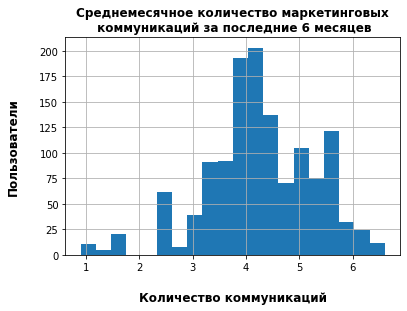

In [47]:
print(market_file['Маркет_актив_6_мес'].describe())
market_file['Маркет_актив_6_мес'].hist(bins=20)
plt.title("Среднемесячное количество маркетинговых\n коммуникаций за последние 6 месяцев", fontsize=12, fontweight="bold")
plt.xlabel("\nКоличество коммуникаций", fontsize=12, fontweight="bold")
plt.ylabel("Пользователи\n",  fontsize=12, fontweight="bold")
plt.show()

Распределение похоже на нормальное с пиком около 4.

Рассмотрим показатель "Маркет_актив_тек_мес", количество маркетинговых коммуникаций в текущем месяце.

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64


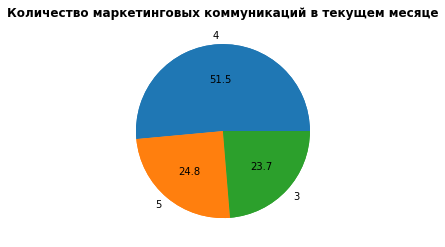

In [48]:
print(market_file['Маркет_актив_тек_мес'].describe())
market_file['Маркет_актив_тек_мес'].value_counts().plot(kind='pie')
plt.title("Количество маркетинговых коммуникаций в текущем месяце", fontsize=12, fontweight="bold")
plt.pie(market_file['Маркет_актив_тек_мес'].value_counts().values, autopct='%.1f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

В основном 4 коммуникации на пользователя, около половины из всех вараинтов. Другая половина это 3 и 5 коммуникации на пользователя, разделенные примерно пополам.

Рассмотрим показатель "Длительность", сколько дней прошло с момента регистрации покупателя на сайте.

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64


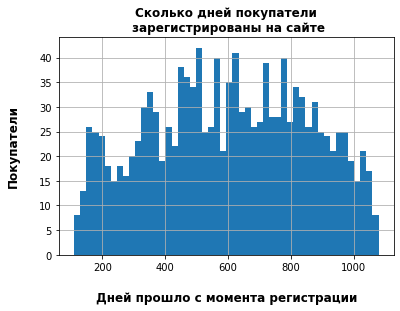

In [49]:
print(market_file['Длительность'].describe())
market_file['Длительность'].hist(bins=50)
plt.title("Сколько дней покупатели\n зарегистрированы на сайте", fontsize=12, fontweight="bold")
plt.xlabel("\nДней прошло с момента регистрации", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Не думаю, что здесь можно говорить о каком-то особом виде распределения. Но можно сказать, что большинство новых регистраций было 400-800 дней назад, и с тех пор количество новых регистраций падает.

Рассмотрим показатель "Акционные_покупки", среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев.

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64


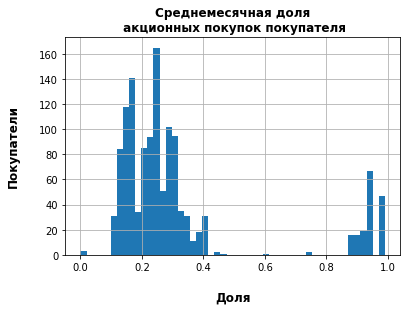

In [50]:
print(market_file['Акционные_покупки'].describe())
market_file['Акционные_покупки'].hist(bins=50)
plt.title("Среднемесячная доля\n акционных покупок покупателя", fontsize=12, fontweight="bold")
plt.xlabel("\nДоля", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Можно сказать, что покупатели разделились на две группы. В покупках бóльшей части покупателей товары со скидкой составляют от 10% до 40%. У меньшей части покупателей товары со скидкой составляют от 90% до почти 100%

Рассмотрим показатель "Средний_просмотр_категорий_за_визит", сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


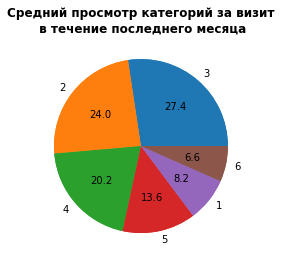

In [51]:
print(market_file['Средний_просмотр_категорий_за_визит'].describe())
market_file['Средний_просмотр_категорий_за_визит'].value_counts().plot(kind='pie')
plt.title("Средний просмотр категорий за визит\n в течение последнего месяца", fontsize=12, fontweight="bold")
plt.pie(market_file['Средний_просмотр_категорий_за_визит'].value_counts().values, autopct='%.1f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

Большинство пользователей просматривает 3, 2 или 4 категории за визит.

Рассмотрим показатель "Неоплаченные_продукты_штук_квартал".

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


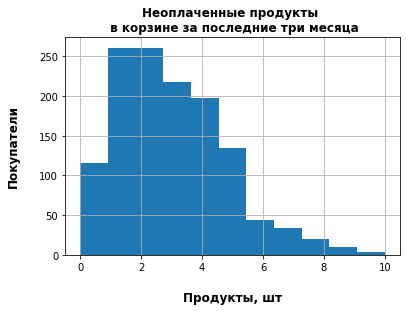

In [52]:
print(market_file['Неоплаченные_продукты_штук_квартал'].describe())
market_file['Неоплаченные_продукты_штук_квартал'].hist(bins=11)
plt.title("Неоплаченные продукты \n в корзине за последние три месяца", fontsize=12, fontweight="bold")
plt.xlabel("\nПродукты, шт", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Максимум 1 или 2 неоплаченных товара, минумум 10 неоплаченных товаров.

Рассмотрим показатель "Ошибка_сервиса".

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64


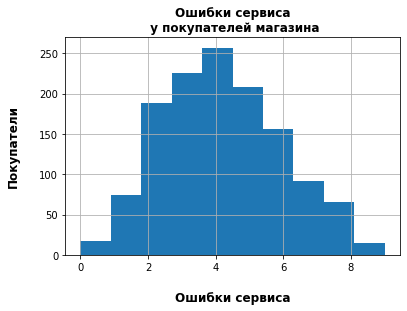

In [53]:
print(market_file['Ошибка_сервиса'].describe())
market_file['Ошибка_сервиса'].hist(bins=10)
plt.title("Ошибки сервиса\n у покупателей магазина", fontsize=12, fontweight="bold")
plt.xlabel("\nОшибки сервиса", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Распределение похоже на нормальное с максимумом равным 4.

Рассмотрим показатель "Страниц_за_визит", среднее количество страниц, просмотренные покупателем за один визит за последние 3 месяца.

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64


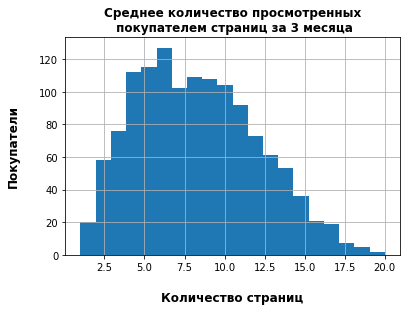

In [54]:
print(market_file['Страниц_за_визит'].describe())
market_file['Страниц_за_визит'].hist(bins=20)
plt.title("Среднее количество просмотренных\n покупателем страниц за 3 месяца", fontsize=12, fontweight="bold")
plt.xlabel("\nКоличество страниц", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Количество резко растет от 1 до максимума в 6 страниц, и потом более плавно падает до 20 страниц.


Рассмотрим показатель "Выручка", выручка от покупателя за месяц.

count    3900.000000
mean     4999.584127
std       706.909334
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64


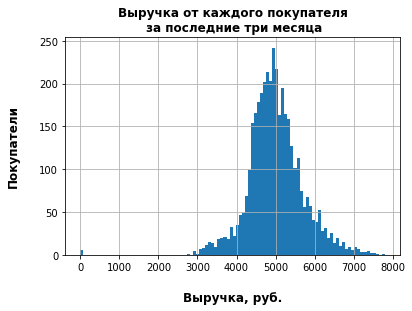

In [55]:
print(market_money['Выручка'].describe())
market_money['Выручка'].hist(bins=100)
plt.title("Выручка от каждого покупателя\n за последние три месяца", fontsize=12, fontweight="bold")
plt.xlabel("\nВыручка, руб.", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Это похоже на нормальное распределение. Максимальное значение выручки на покупателя в месяц чуть меньше 5000 рублей. Столбец с нулевой выручкой мало заметен, но всё же есть покупатели которые совершают покупки не каждый месяц.

Теперь сделаем сводную по покупателям по сумме выручки.

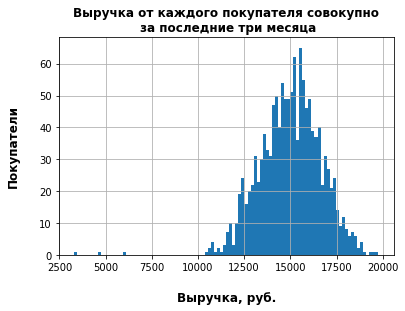

In [56]:
market_money.groupby('id')['Выручка'].agg('sum').hist(bins=100)
plt.title("Выручка от каждого покупателя совокупно\n за последние три месяца", fontsize=12, fontweight="bold")
plt.xlabel("\nВыручка, руб.", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Здесь также нормальное распределение с максимумом чуть больше 15000. Столбца с нулевой выручкой не видно. Проверим, есть ли покупатели без покупок за три месяца.

In [57]:
market_money.groupby('id')['Выручка'].agg('sum').sort_values().head()

id
215348     3293.1
215359     4735.0
215357     5986.3
215564    10437.6
215716    10575.9
Name: Выручка, dtype: float64

Таких покупателей нет, то есть все покупатели тратили деньги в магазине за последние три месяца.

Рассмотрим показатель "минут",время, проведенное на сайте.

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


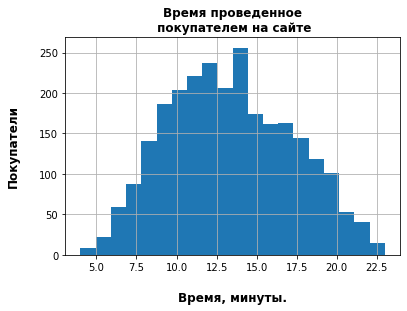

In [58]:
print(market_time['минут'].describe())
market_time['минут'].hist(bins=20)
plt.title("Время проведенное\n покупателем на сайте", fontsize=12, fontweight="bold")
plt.xlabel("\nВремя, минуты.", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Это похоже на нормальное распределение с максимумом около 14 минут.

Рассмотрим показатель "Прибыль".

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


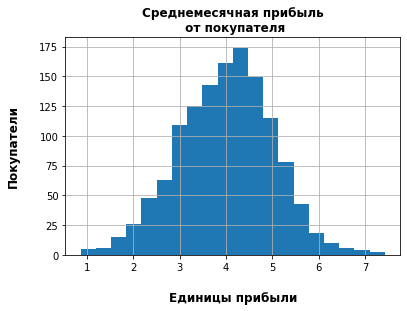

In [59]:
print(money['Прибыль'].describe())
money['Прибыль'].hist(bins=20)
plt.title("Среднемесячная прибыль\n от покупателя", fontsize=12, fontweight="bold")
plt.xlabel("\nЕдиницы прибыли", fontsize=12, fontweight="bold")
plt.ylabel("Покупатели\n",  fontsize=12, fontweight="bold")
plt.show()

Показатель распределен нормальным образом, максимум около 4,2 единиц прибыли.

По покупателям интернет-магазина можно сделать следующие выводы.  
С покупателями в среднем приоисходит около 4 маркетинговых коммуникаций в месяц.    
За последние полтора года снизилось количество новых регистраций на сайте.  
Покупатели делятся на две неравные группы с точки зрения покупки акционных товаров, у большинства доля таких товаров от 10% до 40%, но есть также заметная часть покупателей, которые покупают только или почти только акционные товары.  
В среднем покупатели просматривают от 2 до 4 категорий за визит.  
В основном у покупателей оставалось один или два неоплаченных продуктов за последние три месяца.  
За время работы с сайтом каждый пользователь столкнулся в среднем с 4-мя ошибками работы.  
В среднем за последние три месяца каждый покупатель просмотрел шесть страниц и провел на сайте около 14 минут.  
В среднем каждый месяц покупатель приносит чуть меньше 5000 рублей выручки, при этом нет ни одного покупателя, который за последние три месяца ничего бы не купил.

##  Объединение таблиц

Объединять буду в новый датафрейм main.

In [60]:
main = market_file

In [61]:
#добавление выручки за текущий месяц
table_to_merge = market_money[market_money['Период']=='текущий_месяц'][['id','Выручка']]
main = main.merge(table_to_merge, on='id')
main = main.rename(columns={'Выручка' : 'Выручка_текущий_месяц'})

In [62]:
#добавление выручки за предыдущий месяц
table_to_merge = market_money[market_money['Период']=='предыдущий_месяц'][['id','Выручка']]
main = main.merge(table_to_merge, on='id')
main = main.rename(columns={'Выручка' : 'Выручка_предыдущий_месяц'})

In [63]:
#добавление выручки за препредыдущий месяц
table_to_merge = market_money[market_money['Период']=='препредыдущий_месяц'][['id','Выручка']]
main = main.merge(table_to_merge, on='id')
main = main.rename(columns={'Выручка' : 'Выручка_препредыдущий_месяц'})

In [64]:
#добавление времени на сайте за текущий месяц
table_to_merge = market_time[market_time['Период']=='текущий_месяц'][['id','минут']]
main = main.merge(table_to_merge, on='id')
main = main.rename(columns={'минут' : 'минут_текущий_месяц'})

In [65]:
#добавление времени на сайте за предыдущий месяц
table_to_merge = market_time[market_time['Период']=='предыдущий_месяц'][['id','минут']]
main = main.merge(table_to_merge, on='id')
main = main.rename(columns={'минут' : 'минут_предыдущий_месяц'})

In [66]:
market_money_pivot = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='mean')
market_money_pivot.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [67]:
len(market_money_pivot)

1300

In [68]:
market_time_pivot = market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='mean')
market_time_pivot.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [69]:
main_var2 = market_file.merge(market_money_pivot, on='id').merge(market_time_pivot, on='id')
main_var2 = main_var2.rename(columns={'предыдущий_месяц_x' : 'Выручка_предыдущий_месяц',
                                      'препредыдущий_месяц' : 'Выручка_препредыдущий_месяц',
                                      'текущий_месяц_x' : 'Выручка_текущий_месяц',
                                      'предыдущий_месяц_y' : 'минут_предыдущий_месяц',
                                      'текущий_месяц_y' : 'минут_текущий_месяц'})
main_var2.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [70]:
#Проверка
main.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,3293.1,0.0,0.0,14,13
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8


Найдем индексы строк, в которых выручка нулевая хотя бы в одном из месяцев.

In [71]:
index_to_delete = main[(main['Выручка_препредыдущий_месяц']==0) | 
                       (main['Выручка_предыдущий_месяц']==0) | 
                       (main['Выручка_предыдущий_месяц']==0)].index
index_to_delete

Int64Index([0, 9, 11], dtype='int64')

In [72]:
market_money_pivot3 = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='mean')

In [73]:
#отберем только нужные строки на этапе создания сводной таблицы из таблицы market_money
market_money_pivot3 = market_money_pivot3[(market_money_pivot3['препредыдущий_месяц']>0) & 
                       (market_money_pivot3['предыдущий_месяц']>0) & 
                       (market_money_pivot3['текущий_месяц']>0)]

In [74]:
len(market_file), len(market_money_pivot3), len(market_time_pivot)

(1300, 1297, 1300)

In [75]:
main_var3 = market_file.merge(market_money_pivot3, on='id').merge(market_time_pivot, on='id')

In [76]:
main_var3 = main_var3.rename(columns={'предыдущий_месяц_x' : 'Выручка_предыдущий_месяц',
                                      'препредыдущий_месяц' : 'Выручка_препредыдущий_месяц',
                                      'текущий_месяц_x' : 'Выручка_текущий_месяц',
                                      'предыдущий_месяц_y' : 'минут_предыдущий_месяц',
                                      'текущий_месяц_y' : 'минут_текущий_месяц'})

In [77]:
len(main_var3)

1297

In [78]:
main_var3.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [79]:
#конец варианта №3

Найдено три строки, удалим их.

In [80]:
main = main.drop(index_to_delete)

Проверим.

In [81]:
len(main)

1297

Стало на три строки меньше, всё верно.

На данном этапе три таблицы были объединены в одну таблицу. Для каждого периода по выручке и по времени был создан отдельный столбец. Покупатели без покупок в любой из месяцев из дальнейшего рассмотрения удалены.

## Корреляционный анализ

Не везде выше мы наблюдали нормальное распределение, поэтому используем phik.

In [82]:
interval_cols = ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
                 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
                 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_текущий_месяц',
                 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
                 'минут_текущий_месяц', 'минут_предыдущий_месяц']

In [83]:
main.phik_matrix(interval_cols=interval_cols)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,1.000000,0.984640,0.119882,0.000000,0.468922,0.000000,0.049392,0.414285,0.170373,0.354031,0.417626,0.203942,0.607982,0.171698,0.239152,0.419776,0.472584,0.564821
Покупательская активность,0.984640,1.000000,0.132247,0.000000,0.546370,0.000000,0.101767,0.506991,0.298036,0.539221,0.504845,0.223697,0.748769,0.195470,0.227280,0.495174,0.575662,0.685078
Тип сервиса,0.119882,0.132247,1.000000,0.286278,0.094182,0.044796,0.401158,0.033339,0.066285,0.186635,0.120842,0.076182,0.100832,0.123698,0.000000,0.068507,0.000000,0.131084
Разрешить сообщать,0.000000,0.000000,0.286278,1.000000,0.000000,0.051971,0.253956,0.017252,0.071769,0.069322,0.195442,0.020464,0.041128,0.062923,0.079830,0.000000,0.000000,0.042350
Маркет_актив_6_мес,0.468922,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.286304,0.147270,0.394108,0.032055,0.149129,0.312243,0.328385,0.363780
Маркет_актив_тек_мес,0.000000,0.000000,0.044796,0.051971,0.080454,1.000000,0.174385,0.000000,0.136175,0.246726,0.143827,0.116310,0.000000,0.000000,0.054683,0.000000,0.062485,0.106879
Длительность,0.049392,0.101767,0.401158,0.253956,0.000000,0.174385,1.000000,0.000000,0.000000,0.187774,0.191923,0.174467,0.122727,0.147580,0.125303,0.114058,0.100502,0.024075
Акционные_покупки,0.414285,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.237583,0.000000,0.310741,0.069613,0.065412,0.225681,0.250014,0.262189
Популярная_категория,0.170373,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.248558,0.000000,0.160623,0.237957,0.250974,0.045814,0.089923,0.195219
Средний_просмотр_категорий_за_визит,0.354031,0.539221,0.186635,0.069322,0.205783,0.246726,0.187774,0.199417,0.225622,1.000000,0.325688,0.069908,0.262610,0.092720,0.100332,0.176770,0.182708,0.159393


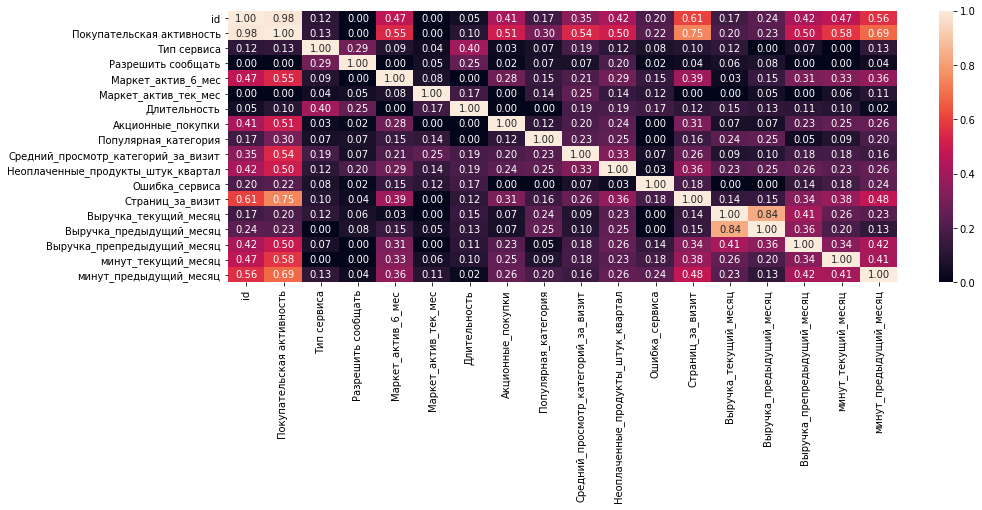

In [84]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(main.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Рассмотрим связь целевого признака, пользовательской активности, с другими параметрами.   
Высокая связь только у параметра "Страниц_за_визит".  
Заметная связь у параметров "Маркет_актив\_6_мес", "Акционные_покупки", "Средний_просмотр_категория_за_визит", "Неоплаченные_покупки_штук_квартал", "минут_текущий_месяц", "минут_предыдущий_месяц".  
Умеренная связь у параметров "популярная категория" и "выручка_препредыддущий_месяц"  
Слабая связь у параметров "тип_сервиса", "ошибка_сервиса", "выручка_текущий_месяц", "выручка_предыдущий_месяц".

Диаграммы рассеяния создавать в данном случае смысла не вижу, поскольку целевой признак категориальный.

Что касается мультиколлинеарности, то поскольку между входными признаками коэффициенты корреляции меньше 0,9 по модулю, то мультиколлинеарности между входными признаками нет.

Выведем отдельно две матрицы корреляции, со снизившейся покупательской активностью и с покупательской активностью без изменений.

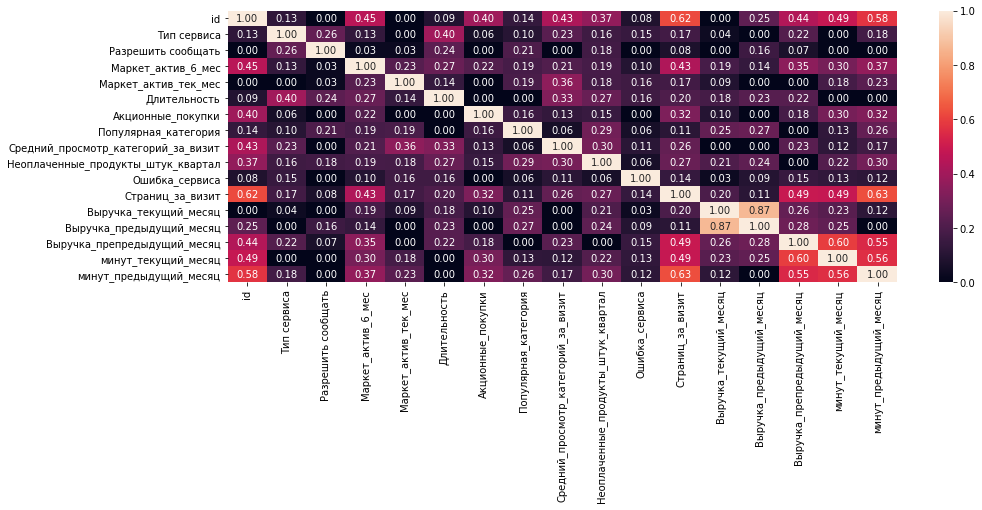

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(main[main['Покупательская активность']=='Снизилась'].phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

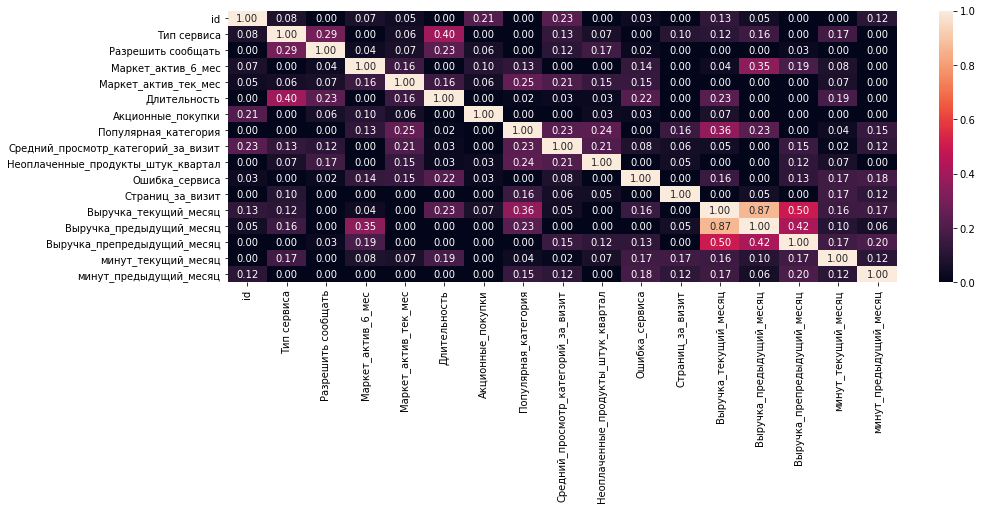

In [86]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(main[main['Покупательская активность']=='Прежний уровень'].phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Сравнив две матрицы можно сказать, что у покупателей со снизившейся покупательской активностью значительно большая связь признака «страниц за визит»  с признаками «минут текущий месяц» и «минут предыдущий месяц».  
Также у покупателей со снизившейся покупательской активностью явно отличается признак «Выручка препредыдущий  месяц», есть существенно большая связь с признаками «минут текущий месяц», «минут предыдущий месяц» и «прибыль».  
То есть, если правильно понимаю, такие сочетания признаков позволяют выделить как раз покупателей со снизившейся покупательской активностью.  
Если взять покупателей, у которых активность осталась на прежнем уровне, то у них можно выделить значительно большую связь признака «прибыль» с признаками «акционные покупки», «неоплаченные продукты», «выручка текущий месяц» и «минут текущий месяц».

Вывод по этому этапу.   
С целевым признаком высокая корреляция только у одного признака "Страниц_за_визит".

## Использование пайплайнов

In [87]:
main = main.set_index('id')
main

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7,14
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11,12
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18,12


In [88]:
X = main.drop(columns=['Покупательская активность'], axis=1)
y = main['Покупательская активность']

RANDOM_STATE = 42
TEST_SIZE = 0.25

#стратификация по целевому признаку y
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# создаём списки с названиями признаков
ohe_columns = ['Популярная_категория', 'Разрешить сообщать']
ord_columns = ['Тип сервиса']

num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса',
               'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', 
               'Выручка_препредыдущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']

#создаём пайплайн для подготовки признаков из списка ohe_columns

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error',  sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_befor_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
            categories=[
                ['стандарт', 'премиум']
            ], 
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )
    ), 
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])



In [89]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver=['lbfgs','newton-cg','liblinear','sag','saga'],
                                      penalty= ['l1', 'l2', 'elasticnet', 'none'])
                  ],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
     # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,kernel='rbf',probability=True)],
        'models__degree': range(2, 5),
        'models__C': range(1, 10),
        'models__gamma': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


В качестве метрики буду использовать roc_auc, совмещающий смысл метрик TPR и FPR, и являющийся поэтому более универсальным методом оценки качества бинарной классификации.

In [90]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

#y_test_pred = randomized_search.predict(X_test)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
#print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor_ord',
                                             

In [91]:
#type(y_train)
y_train
randomized_search.best_score_

0.9104544970590425

In [92]:
y_test_text_result = randomized_search.predict(X_test)
#y_test_text_result 

In [93]:
y_test_pred = randomized_search.predict_proba(X_test)
#y_test_pred

In [94]:
# 'Снизилась' соответствует 1
y_test_pred_one = y_test_pred[:, 1]
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_score(y_test, y_test_pred_one))

Площадь ROC-кривой на тестовой выборке: 0.91427940940459


In [95]:
y_train_pred_one = randomized_search.predict_proba(X_train)[:, 1]
print('Площадь ROC-кривой на тренировочной выборке:', roc_auc_score(y_train, y_train_pred_one))

Площадь ROC-кривой на тренировочной выборке: 0.9386086082943521


Был использован один общий пайплайн с выбором лучшей модели.  
Лучшей моделью оказалась KNeighborsClassifier c neighbors=87.

Полученные метрики как на тренировочной, так и тестовой модели достаточно высоки. Поэтому останавливаюсь на полученном варианте.

Вывод по этому этапу.  
Ипользовался один общий пайплайн, были обучены четыре модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().
Лучшей моделью оказалась KNeighborsClassifier. В качестве метрики использовалась ROC-AUC. Метрика лучшей модели 0,914 на тренировочной выборке и 0,920 на тестовой выборке.

## Анализ важности признаков

Нам необходимо оценить важность признаков для модели и построить график важности признаков, используя SHAP, т.е. показать вклад каждого признака в предсказания.  
Будем использовать три графика, два из которых показывают общую значимость признаков, и ещё один показывает вклад каждого признака в классификацию отдельного наблюдения.

In [96]:
explainer = shap.KernelExplainer(randomized_search.predict_proba, X_test[:20],keep_index=True)

Графики строились по 325 значениям.  
https://disk.yandex.ru/i/nlvBnMcKepIBiQ

In [97]:
shap_values = explainer(X[:20])

  0%|          | 0/20 [00:00<?, ?it/s]

shap.plots.beeswarm картинкой.  
https://disk.yandex.ru/i/AfR8SJM2LmOElQ

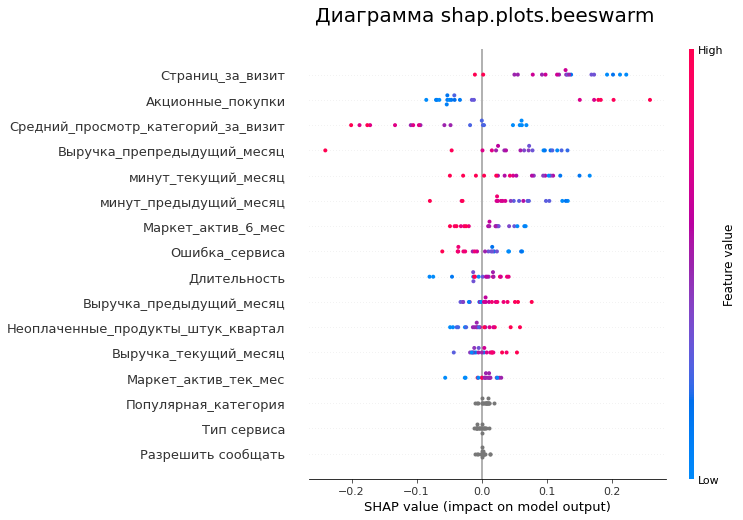

In [98]:
plt.title("Диаграмма shap.plots.beeswarm \n",fontsize=20)
shap.plots.beeswarm(shap_values[:,:,1], max_display=16) 

Признаки расположены сверху вних в порядке убывания средних SHAP‑значений, т.е. вклада каждого признака в предсказания.
Красные точки справа от вертикальной оси говорят о том, что признак склоняет модель отнести объекты к классу 1. Синие точки слева от вертикальной оси говорит о том, что признак склоняет модель отнести объекты к классу 0.  
Цвет точки отражает значения каждого признака объекта, чем краснее точка тем больше признак.  
С учетом, этого и того, что ранее было установлено, что "Снизилось" соответствует единице, а "Прежний уровень" соответствует нулю, можно сказать, что наиболее важные признаки это:  
акционные покупки, большое значение акционных покупок склоняют модель к "Снизилось", а низкое к "Прежний уровень",  
средний просмотр категорий за визит, большие значение признака склоняют модель к "Прежний уровень", а низкие значения признака склоняют модель к предскзанию "Снизилось".  
При этом наиболее важными признаками являются "Страниц за визит" и "Минут предыдущий месяц", но про них можно сказать, что низкие значения признака склоняют модель к "Снизилось", но высокие значения этих признаков склоняют модель тоже к "Снизилось", но в значительно меньшей степени.


In [99]:
best_model = randomized_search.best_estimator_

График shap.plots.bar картинкой.  
https://disk.yandex.ru/i/KRQNI76Qjff2GQ

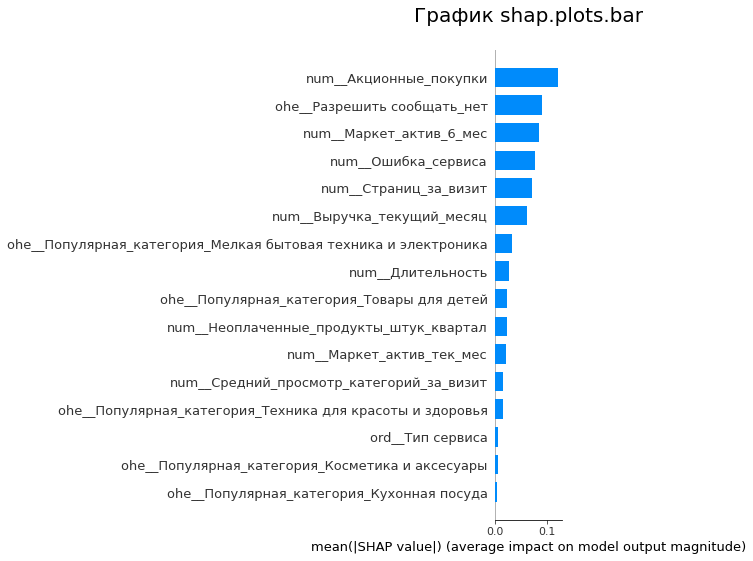

In [100]:
plt.title("График shap.plots.bar\n",fontsize=20)
shap.summary_plot(shap_values[:,:,1], plot_type="bar",  feature_names= best_model.named_steps['preprocessor'].get_feature_names_out())

Столбчатая диаграмма shap.plots.bar отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака, взятые по модулю.  
С точки зрения этой диаграммы самые большой вес в предсказания модели вносят признаки акционные покупки и выручка за текущий месяц.


График shap.plots.waterfall картинкой.  
https://disk.yandex.ru/i/o8CJYx5dNGXUVA

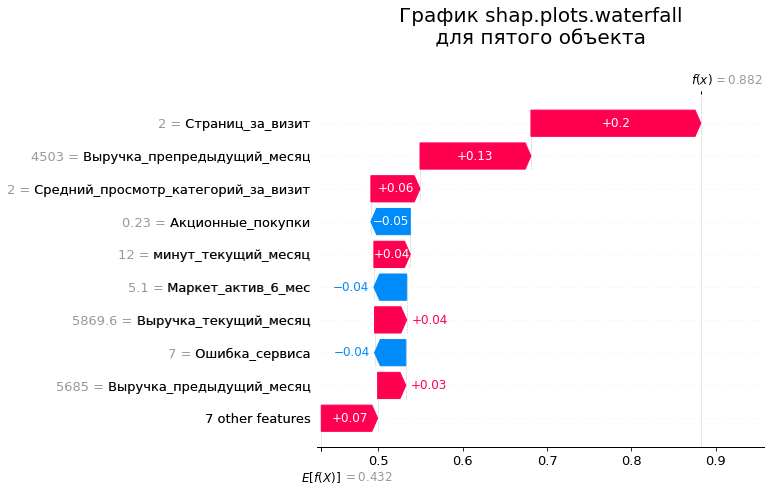

In [101]:
plt.title("График shap.plots.waterfall\n для пятого объекта \n",fontsize=20)
shap.plots.waterfall(shap_values[5,:,1]) 

График shap.plots.waterfall визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете.  
Наиболее влияет на классификацию пятого объекта признак "Страниц за визит", он перетяивает предсказание в сторону класса 1. В меньшей степени, но тоже в сторону класса 1 перетягивают предсказание признаки "Выручка_препредыдущий_месяц" и "Средний просмотр категорий за визит".  
В сторону класса 0 наиболее склоняет предсказание признак "Маркет_актив\_6_мес".  
Остальные признаки менее значимы.


Вывод по этапу "Анализ важности признаков".  
Было установлено, что наиболее влияют на предсказание модели признаки:
- страниц за визит,
- минут предыдущий месяц,
- акционные покупки,
- минут текущий месяц,
- средний просмотр категорий за визит.  

Почти никак или очень мало влияют признаки:  
- популярная категория,
- тип сервиса,
- разрешить сообщать.

Что касается моделирования, ничтожно влияющие признаки, полагаю можно вообще убрать из модели.  
Что касается принятия бизнес-решений, то можно сказать следующее. Например, можно отслеживать признаки наиболее однозначно влияющие на покупательскую активность, т.е. акционные покупки, средний просмотр категорий за визит и неоплаченные продукты за квартал. Видя, что у покупателя большая доля акционных покупок, низкий средний просмотр категорий и много неоплаченных продуктов за квартал, можно с высокой долей вероятности говорить о будущем снижении покупательской активности. Понимая это, бизнес может начать придумывать, как удержать клиента, но сможет это делать целенаправленно, видя, где есть проблема, а где её нет.

## Сегментация покупателей

Добавим прибыль в основной датафрейм.

In [102]:
money = money.set_index('id')
#money

In [103]:
main = main.join(money)
#main

В качестве сегмента беру один из предложенных в проекте вариантов, а именно "Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом", то есть покупателей с популярной категорией 'Мелкая бытовая техника и электроника'.

Добавим probas, т.е вероятности снижения покупательской активности в основной датафрейм.

In [104]:
probas = randomized_search.predict_proba(X)[:, 1]
len(probas)

1297

In [105]:
main['вероятность_снижения'] = probas

In [106]:
main.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,Прибыль,вероятность_снижения
id,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12,4.16,1.000000
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8,3.13,0.411765
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11,4.87,0.882353
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8,4.21,0.882353
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10,3.95,0.705882


В качестве сегмента выберем группу клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.  
Поскольку у нас точных данных о структуре покупок клиентов, критерием того, что покупатель относится к этой группе будет являться его принадлежность к популярной категории "Мелкая бытовая техника и электроника".  
Задавать отбор по признаку "вероятность_снижения" я не вижу смысла, так как нам и нужно будет сравнивать покупателей с разными вероятностями снижения покупательской активности, чтобы понять, чем они отличаются друг от друга.  
Но возможно есть смысл задать отбор по выручке. Предварительно отберем сначала только по признаку 'Популярная_категория'.

In [107]:
segment = main[(main['Популярная_категория']=='Мелкая бытовая техника и электроника')]
len(segment)

174

In [108]:
segment['Прибыль'].sum()

685.28

Вся прибыль 685,28 единиц на 174 покупателя. Согласно исследовательскому анализу данных прибыль лежит в диапазоне от 0,86 до 7,43. Попробуем задать отбор по прибыли.

При отборе по прибыли больше 1,5.

In [109]:
segment[segment['Прибыль']>1.5]['Прибыль'].sum()

683.04

In [110]:
segment[segment['Прибыль']>1.5]['Прибыль'].count()

172

При отборе по прибыли больше 2.

In [111]:
segment[segment['Прибыль']>2]['Прибыль'].sum()

674.6700000000001

In [112]:
segment[segment['Прибыль']>2]['Прибыль'].count()

167

При отборе по прибыли больше 3.

In [113]:
segment[segment['Прибыль']>3]['Прибыль'].sum()

626.6200000000001

In [114]:
segment[segment['Прибыль']>3]['Прибыль'].count()

148

При отборе по прибыли больше 4.

In [115]:
segment[segment['Прибыль']>4]['Прибыль'].sum()

400.56000000000006

In [116]:
segment[segment['Прибыль']>4]['Прибыль'].count()

84

Из всех вариантов отбора по прибыли разумным и достаточным мне представляется отбор больше 3, при котором остается бо́льшая часть прибыли, но сокращается количество покупателей.

In [117]:
segment = segment[segment['Прибыль']>3]
len(segment)

148

Построим диаграммы рассеяния для признаков "Прибыль" и "вероятность_снижения" с учетом категориальных признаков.  
Цель - увидеть какую-нибудь явную закономерность.

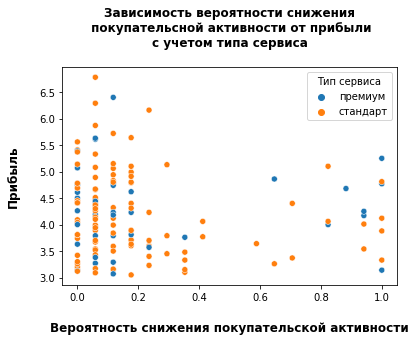

In [118]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Тип сервиса')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс учетом типа сервиса\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
display()

Доля покупателей с типом сервиса "Премиум" в правой части графика, т.е. там где вероятность снижения покупательской активности велика, несколько больше, чем в левой части.

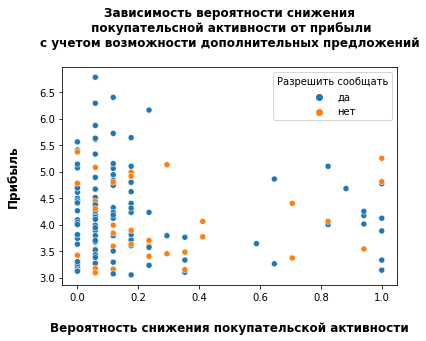

In [119]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Разрешить сообщать')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс учетом возможности дополнительных предложений\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
display()

Среди покупателей с большой вероятностью снижения покупательской активности значительно больше тех, кто получает дополнительные предложения. Видимо предложения их не устраивают.

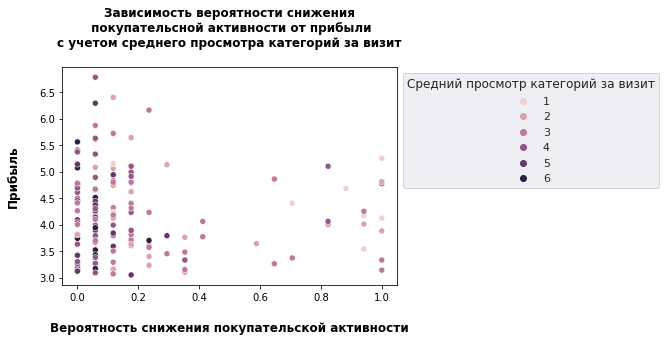

In [120]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Средний_просмотр_категорий_за_визит')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс учетом среднего просмотра категорий за визит\n", fontsize=12, fontweight="bold")
sns.set_theme(rc={'figure.figsize':(10,8)})
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
plt.legend(loc='upper left', title='Средний просмотр категорий за визит',bbox_to_anchor=(1,1)) 
display()

Здесь явно видно, что покупатели с низкой вероятностью снижения покупательской активности смотрят больше категорий.

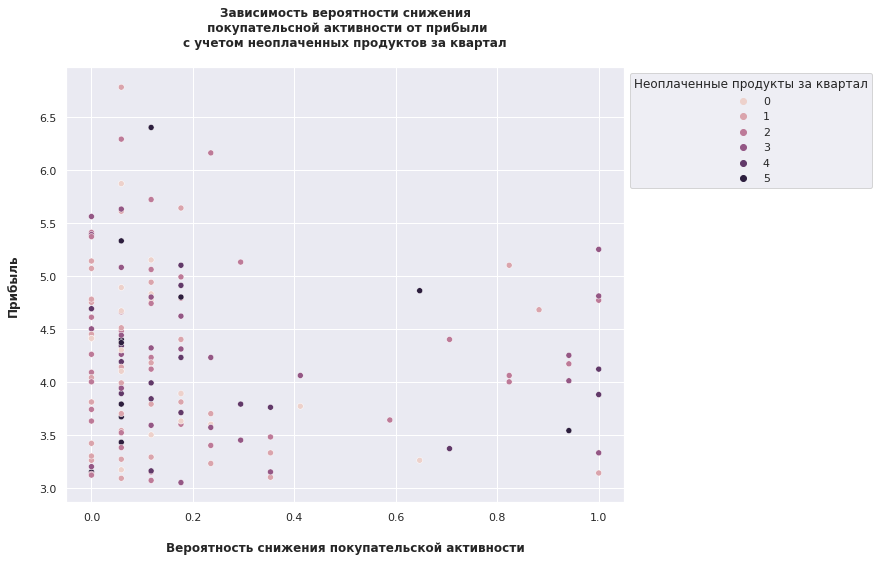

In [121]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Неоплаченные_продукты_штук_квартал')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс учетом неоплаченных продуктов за квартал\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
sns.set_theme(rc={'figure.figsize':(10,8)})
plt.legend(loc='upper left', title='Неоплаченные продукты за квартал',bbox_to_anchor=(1,1)) 
display()

Здесь видно, что среди покупателей с высокой вероятностью снижения покупательской активности значительно больше доля тех, кто кладет в корзину товар, но в итоге не оплачивает. Можно предположить, что не устраивает цена.

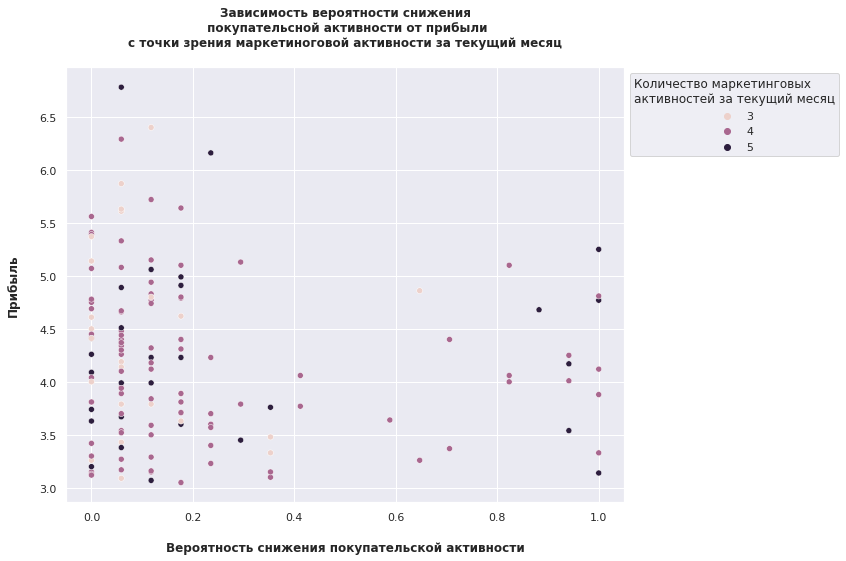

In [122]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Маркет_актив_тек_мес')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс точки зрения маркетиноговой активности за текущий месяц\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
plt.legend(loc='upper left', title='Количество маркетинговых \nактивностей за текущий месяц',bbox_to_anchor=(1,1))
display()

Здесь видно, что среди покупателей с высокой вероятностью снижения покупательской активности больше доля тех, у кого было велика маркетинговая активность за текущий месяц. 

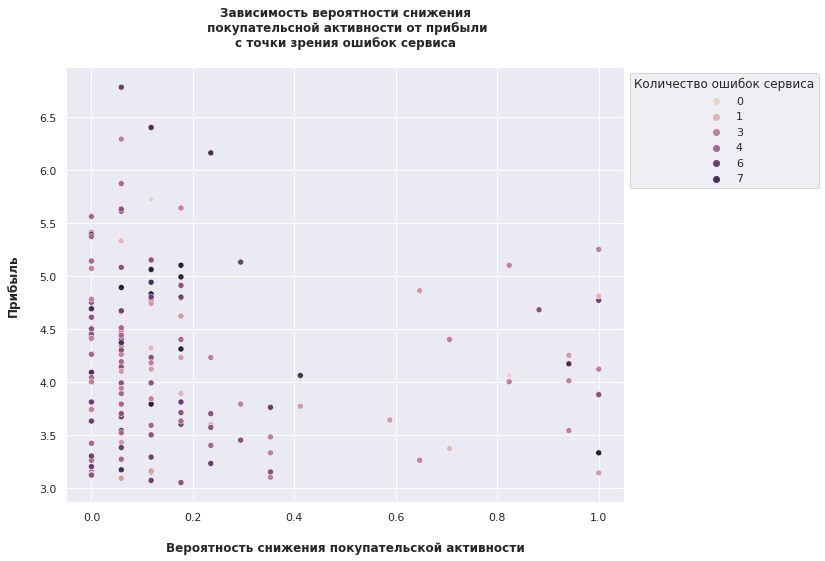

In [123]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Ошибка_сервиса')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс точки зрения ошибок сервиса\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
plt.legend(loc='upper left', title='Количество ошибок сервиса',bbox_to_anchor=(1,1))
display()

Можно сделать вывод, что ошибки сервиса не имеют принципиального значения.

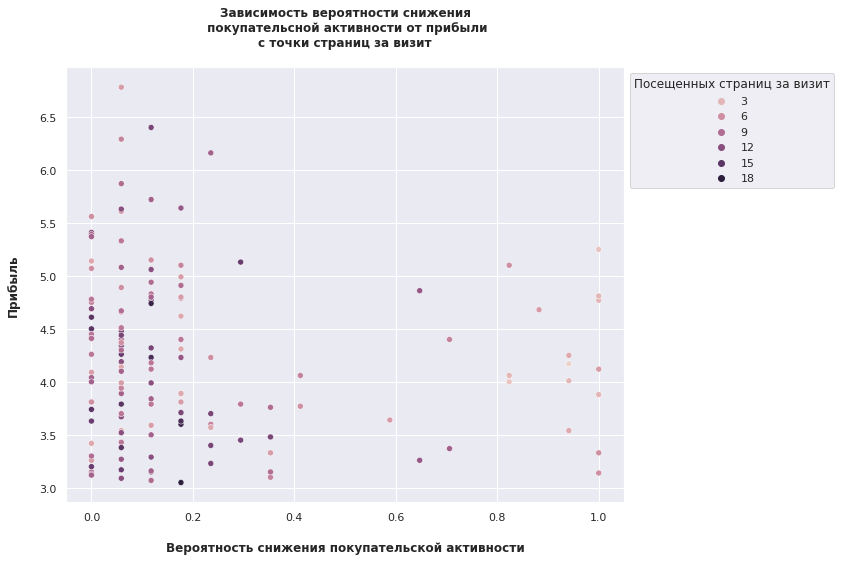

In [124]:
sns.scatterplot(data=segment, x="вероятность_снижения", y="Прибыль", hue='Страниц_за_визит')
plt.title("Зависимость вероятности снижения\n покупательсной активности от прибыли\nс точки страниц за визит\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения покупательской активности", fontsize=12, fontweight="bold")
plt.ylabel("Прибыль\n",  fontsize=12, fontweight="bold")
plt.legend(loc='upper left', title='Посещенных страниц за визит',bbox_to_anchor=(1,1))
display()

Покупатели с большей вероятностью снижения покупательской активности просматривают явно меньше страниц за визит.

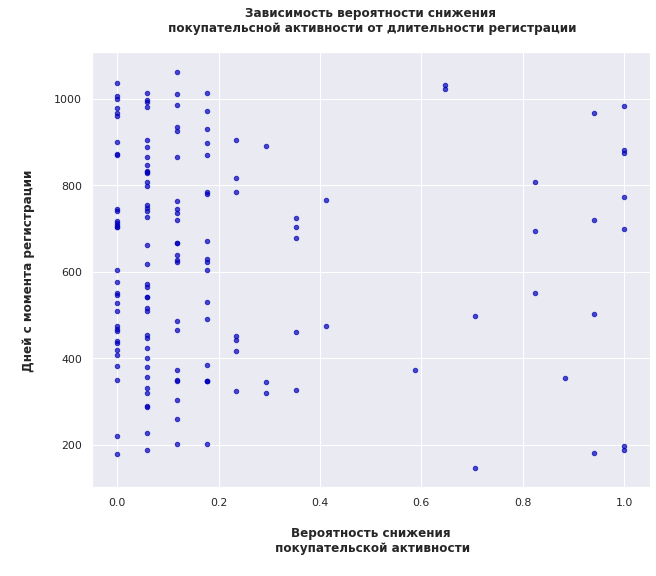

In [125]:
segment.plot(y='Длительность', x='вероятность_снижения',kind='scatter', alpha=0.7, color='#0000BB')
plt.title("Зависимость вероятности снижения\n покупательсной активности от длительности регистрации\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения\n покупательской активности\n", fontsize=12, fontweight="bold")
plt.ylabel("\nДней с момента регистрации\n",  fontsize=12, fontweight="bold")
display()

Зависимости между длительностью регистрации и вероятностью снижения покупательской активности не наблюдается.

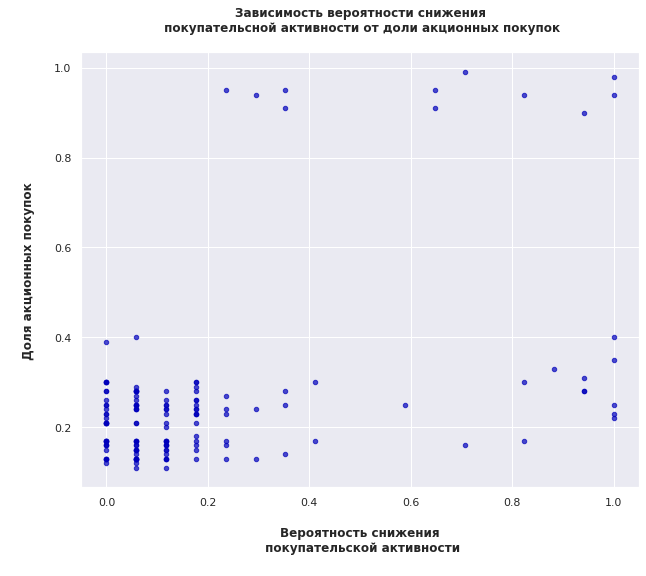

In [126]:
segment.plot(y='Акционные_покупки', x='вероятность_снижения',kind='scatter' , alpha=0.7, color='#0000BB')
plt.title("Зависимость вероятности снижения\n покупательсной активности от доли акционных покупок\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения\n покупательской активности\n", fontsize=12, fontweight="bold")
plt.ylabel("\nДоля акционных покупок\n",  fontsize=12, fontweight="bold")
display()

Здесь можно сказать, что покупатели делятся на две группы, одна из которых покупает почти только акционные товары, у другой доля акционных товаров не более 40 %. Но зависимости между длительностью регистрации и вероятностью снижения покупательской активности также на наблюдается.   

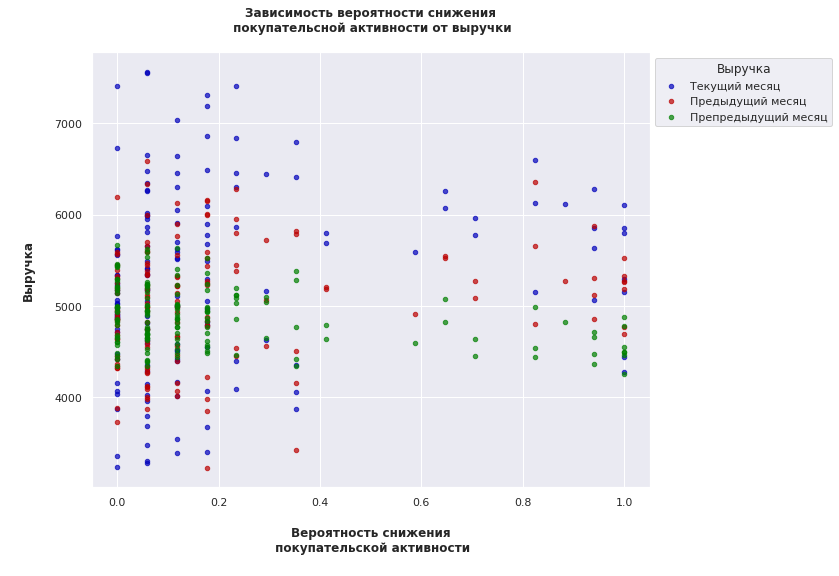

In [127]:
ax = segment.plot(y='Выручка_текущий_месяц', x='вероятность_снижения',kind='scatter' , alpha=0.7, color='#0000BB')
segment.plot(y='Выручка_предыдущий_месяц', x='вероятность_снижения',kind='scatter' , alpha=0.7, color='#BB0000', ax=ax)
segment.plot(y='Выручка_препредыдущий_месяц', x='вероятность_снижения',kind='scatter' , alpha=0.7, color='green', ax=ax)
plt.title("Зависимость вероятности снижения\n покупательсной активности от выручки\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения\n покупательской активности\n", fontsize=12, fontweight="bold")
plt.ylabel("\nВыручка\n",  fontsize=12, fontweight="bold")
plt.legend(['Текущий месяц', 'Предыдущий месяц', 'Препредыдущий месяц'], loc='upper left', title='Выручка',bbox_to_anchor=(1,1))
display()

Из графика видно, что выручка по покупателям бытовой техники отличается по месяцам с точки зрения разброса. В препредыдущем месяца выручка находится с самом узком диапазоне значений, в предыдущем месяце этот диапазон более широк, в текущем месяце он самый широкий.  
Но с точки зрения вероятности снижения покупательской активности разницы тоже не наблюдаю.

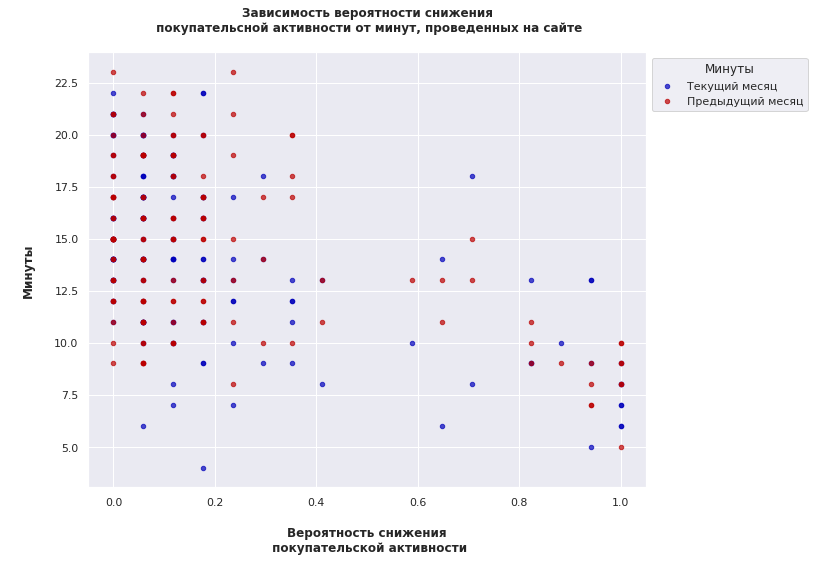

In [128]:
ax = segment.plot(y='минут_текущий_месяц', x='вероятность_снижения',kind='scatter' , alpha=0.7, color='#0000BB')
segment.plot(y='минут_предыдущий_месяц', x='вероятность_снижения',kind='scatter' , alpha=0.7, color='#BB0000', ax=ax)
plt.title("Зависимость вероятности снижения\n покупательсной активности от минут, проведенных на сайте\n", fontsize=12, fontweight="bold")
plt.xlabel("\nВероятность снижения\n покупательской активности\n", fontsize=12, fontweight="bold")
plt.ylabel("\nМинуты\n",  fontsize=12, fontweight="bold")
plt.legend(['Текущий месяц', 'Предыдущий месяц'], loc='upper left', title='Минуты',bbox_to_anchor=(1,1))
display()

Здесь зависимость видна. Покупатели с высокой вероятностью снижения покупательской способности в целом меньше времени проводили на сайте.

Вывод по этапу.  
Покупатели с высокой вероятностью снижения покупательской активности просматривают меньше страниц, меньше категорий, меньше времени проводят на сайте, а также чаще кладут товар в корзину, но не сделав заказа.  
Возможно стоит изменить маркетинг в сторону предложения товара других категорий, которые покупатель обычно не смотрит. Это должны быть конкурентные предложения, возможны товары по акции со скидкой. Смысл в том, чтобы заинтересовать покупателя товарами других категорий, которые он возможно привык покупать в другом месте или даже просто не знает, что в этом магазине такие товары тоже продаются.  
Если покупатель кладет товар в корзину, но не оплачивает, то очевидно, что его не совсем устраивает цена, и возможно существуют более дешевые предложения других магазинов. Возможно имеет смысл разработвать систему накопительных баллов, чтобы покупатель мог сам себе сделать некоторую скидку на нужный ему товар, но не пошел бы к конкуренту.

## Общий вывод

Целью задачи было создать решение для интернет-магазина, позволяюще предсказывать снижение покупательской активности клиентов магазина для дальнейшего создание персональных предложений постоянным клиентам.  

Исходными данными были четыре файла с данными об покупательской активности на сайте, о выручке, времени, проведенном покупателем на сайте, а также прибыли от каждого покупателя.
На этапе предобработки данных были устранены описки в значениях столбцов, устранен один явный выброс в столбце с выручкой. Других изменений вносить не пришлось, задвоений и пустых ячеек найдено не было.   

Для поиска лучшей модели использовался один общий пайплайн с моделями DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC. Назначались разные гиперпараметры моделей с целью найти лучший вариант, например для DecisionTreeClassifier это параметры max_depth и max_features, для KNeighborsClassifier менялось значение neighbors, для LogisticRegression это параметр penalty, 'l1' или 'l2', для SVC это гиперпараметры C и gamma, а также собственно ядра 'rbf', 'sigmoid', 'linear', 'poly'.

Лучшей моделью оказалась KNeighborsClassifier, метод k-ближайших соседей, k получилось равным 87.

Среди сегментов покупателей была взята группа покупателей с популярной категорией 'Мелкая бытовая техника и электроника'. Было выяснено, что покупатели с снизившейся покупательской активностью просматривают меньше категорий, меньше страниц, меньше проводят времени на сайте, а также чаще не заказывают отложенный в корзину товар.   
Исходя из этого было сделано предположение, что таким клиентам стоит предлагать товар из других категорий, которые они обычно не смотрят, и возможно предлагать акционный товар из других категорий, чтобы сподвигнуть их к расширению просматриваемых категорий, что в итоге должно привести и к появлению продаж в новых для покупателей категориях, и таким образом к общему приросту продаж и сохранению покупательской активности на прежнем уровне.